<a href="https://colab.research.google.com/github/wannleach/MAT-421/blob/main/Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from scipy import optimize

# Read in data
df = pd.read_csv('/content/Alzheimers.csv')

# Combine 'YearStart' and 'YearEnd' column
df_long = pd.melt(df, id_vars = ['Data_Value', 'Data_Value_Type', 'Topic', 'LocationDesc'], value_vars = ['YearStart', 'YearEnd'], var_name = 'Start/End ID', value_name = 'Year')

# Sort 'Year' in ascending order
df_sorted = df_long.sort_values(by = 'Year')

# Filter out NaN values
df_sorted_NaN = df_sorted.dropna(subset=['Data_Value'])

# Filter for percent data type
df_sorted_NaN_percent = df_sorted_NaN[df_sorted_NaN['Data_Value_Type'] == 'Percentage']

# Filter rows for physical and cognitive health
df_physical = df_sorted_NaN_percent[df_sorted_NaN_percent['Topic'].str.contains('(fair to poor health)|unhealthy')];
df_cognitive = df_sorted_NaN_percent[df_sorted_NaN_percent['Topic'].str.contains('cognitive decline')];

# Group by states for comparison of trends
#df_physical_states = df_physical.groupby(['LocationDesc'])
#df_cognitive_states = df_cognitive.groupby(['LocationDesc'])

# Extract independent and dependent variables for simplicity
years_physical = np.array((df_physical['Year']))
years_cognitive = np.array((df_cognitive['Year']))

percent_physical = np.array((df_physical['Data_Value']))
percent_cognitive = np.array((df_cognitive['Data_Value']))

<ipython-input-2-ac3522edb64d>:8: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Alzheimers.csv')
<ipython-input-2-ac3522edb64d>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_physical = df_sorted_NaN_percent[df_sorted_NaN_percent['Topic'].str.contains('(fair to poor health)|unhealthy')];


Interpolation Calculation

In [10]:
# Years for Interpolation
years_interpol = np.arange(2015, 2020, 1 / 12)                                                                    # from 2015 to 2020 w/ 1 month intervals

# Linear Interpolation
lin_interpol_physical_func = interp1d(years_physical, percent_physical)                                           # PHYSICAL health linear interpolation
lin_interpol_cognitive_func = interp1d(years_cognitive, percent_cognitive)                                        # COGNITIVE health linear interpolation

percent_physical_lin = lin_interpol_physical_func(years_interpol)                                                 # PHYSICAL health linear calc
percent_cognitive_lin = lin_interpol_cognitive_func(years_interpol)                                               # COGNITIVE health linear calc

# Find unique values of years and corresponding percents for Cubic Spline requirements
unique_years_physical, index = np.unique(years_physical, return_index=True)                                       # PHYSICAL health unique years
unique_percent_physical = percent_physical[index]                                                                 # PHYSICAL health corresponding percent

unique_years_cognitive, index = np.unique(years_cognitive, return_index=True)                                     # COGNITIVE health unique years
unique_percent_cognitive = percent_cognitive[index]                                                               # COGNITIVE health corresponding percent

# Cubic Spline Interpolation
cubic_interpol_physical_func = CubicSpline(unique_years_physical, unique_percent_physical, bc_type='natural')     # PHYSICAL health cubic spline interpolation
cubic_interpol_cognitive_func = CubicSpline(unique_years_cognitive, unique_percent_cognitive, bc_type='natural')  # COGNITIVE health cubic spline interpolation

percent_physical_cubic = cubic_interpol_physical_func(years_interpol)                                             # PHYSICAL health cubic spline calc
percent_cognitive_cubic = cubic_interpol_cognitive_func(years_interpol)                                           # COGNITIVE health cubic spline calc

Regression Calculation

In [11]:
# Define linear function for regression w/ linear interpolation dataset
def linear_func(x, a, b):
  return a * x + b

# Define quadratic function for regression w/ linear interpolation dataset
def quadratic_func(x, a, b, c):
  return a * x**2 + b * x + c

# Define cubic function for regression w/ cubic spline dataset
def cubic_func(x, a, b, c, d):
  return a * x**3 + b * x**2 + c * x + d

# Fit linear regression for linear interpolation dataset
popt_physical_lin_linreg = optimize.curve_fit(linear_func, years_interpol, percent_physical_lin)[0]
popt_cognitive_lin_linreg = optimize.curve_fit(linear_func, years_interpol, percent_cognitive_lin)[0]

# Fit quadratic regression for linear interpolation dataset
popt_physical_lin_quadreg = optimize.curve_fit(quadratic_func, years_interpol, percent_physical_lin)[0]
popt_cognitive_lin_quadreg = optimize.curve_fit(quadratic_func, years_interpol, percent_cognitive_lin)[0]

# Fit cubic regression for cubic interpolation dataset
popt_physical_cubic_cubicreg = optimize.curve_fit(cubic_func, years_interpol, percent_physical_cubic)[0]
popt_cognitive_cubic_cubicreg = optimize.curve_fit(cubic_func, years_interpol, percent_cognitive_cubic)[0]


Interpolation & Regression Plotting

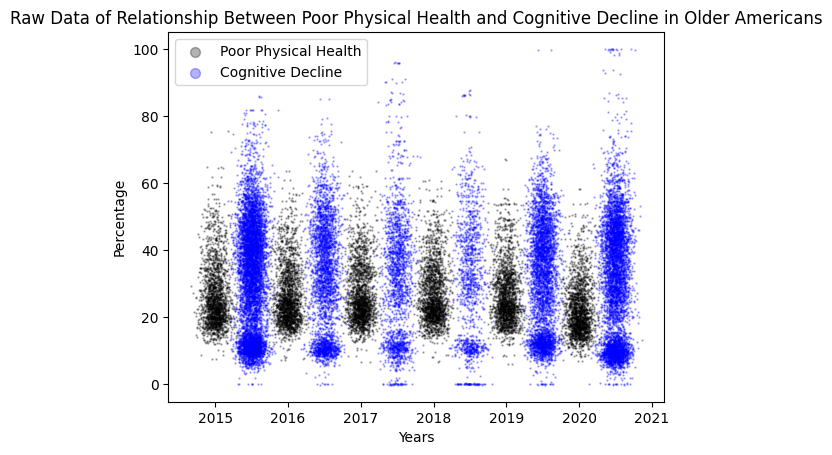

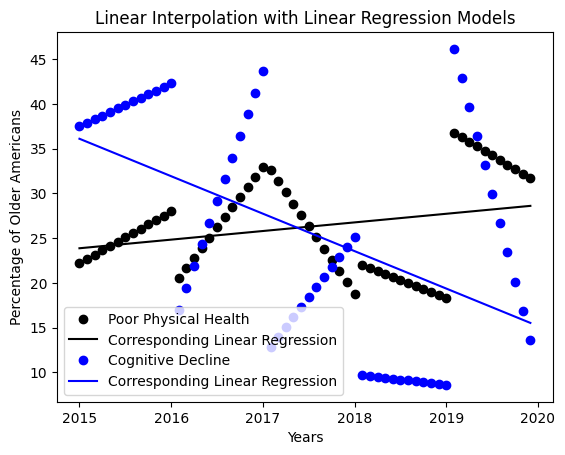

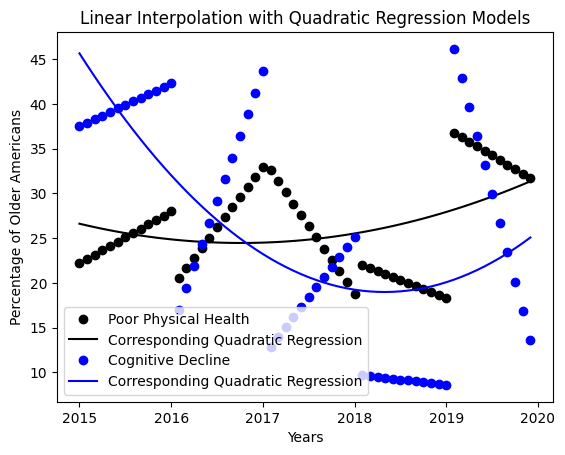

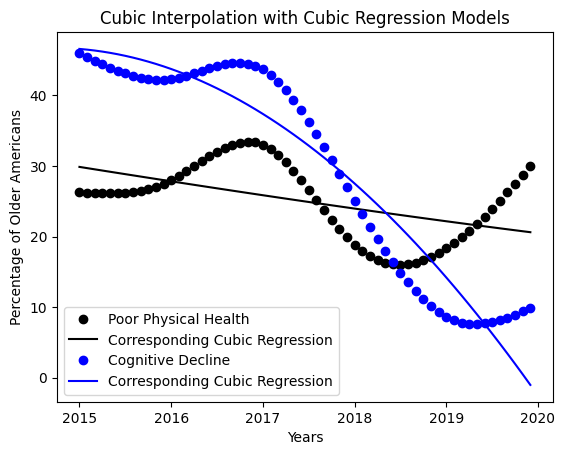

In [12]:
# Plotting Params
alpha = 0.3                                                                                                 # transparency for scatter plot
s = 0.5                                                                                                     # size of points for scatter plot
figsize = (6.4, 4.8)                                                                                        # default value for figure size
marker = 'o'                                                                                                # shape of points
linestyle_interpol = ''                                                                                    # line style for interpolated data
linestyle_reg = '-'                                                                                         # line style for regression curves
color_physical = 'k'                                                                                        # black coloring for physical health
color_cognitive = 'b'                                                                                       # blue coloring for cognitive health


# Raw Data Jittering
jitter = 0.1
years_physical_jittered = years_physical + jitter * np.random.randn(len(years_physical))                    # jitter physical year values
percent_physical_jittered = percent_physical + jitter * np.random.randn(len(percent_physical))              # jitter physical percent values
years_cognitive_jittered = years_cognitive + jitter * np.random.randn(len(years_cognitive)) + 0.5           # jitter cognitive year values and add an offset of 0.5
percent_cognitive_jittered = percent_cognitive + jitter * np.random.randn(len(percent_cognitive))           # jitter cognitive percent values


# Raw Data Plotting
plt.figure(figsize = figsize)
plt.scatter(years_physical_jittered, percent_physical_jittered, marker = marker, c = color_physical, s = s, alpha = alpha, label="Poor Physical Health")
plt.scatter(years_cognitive_jittered, percent_cognitive_jittered, marker = marker, c = color_cognitive, s = s, alpha = alpha, label="Cognitive Decline")
plt.xlabel('Years')
plt.ylabel('Percentage')
plt.title('Raw Data of Relationship Between Poor Physical Health and Cognitive Decline in Older Americans')
plt.legend(markerscale = 10)
plt.savefig('raw.png', bbox_inches='tight')


# Linear Interpolation & Linear Regression Plotting
plt.figure(figsize = figsize)

plt.plot(years_interpol, percent_physical_lin, 
         color=color_physical, marker=marker, linestyle=linestyle_interpol, label='Poor Physical Health')
plt.plot(years_interpol, linear_func(years_interpol, *popt_physical_lin_linreg), 
         color=color_physical, linestyle=linestyle_reg, label='Corresponding Linear Regression')

plt.plot(years_interpol, percent_cognitive_lin, 
         color=color_cognitive, marker=marker, linestyle=linestyle_interpol, label='Cognitive Decline')
plt.plot(years_interpol, linear_func(years_interpol, *popt_cognitive_lin_linreg), 
         color=color_cognitive, linestyle=linestyle_reg, label='Corresponding Linear Regression')

plt.xlabel('Years')
plt.ylabel('Percentage of Older Americans')
plt.title('Linear Interpolation with Linear Regression Models')
plt.legend(loc='lower left')
plt.savefig('linear_interpol_linear_reg.png', bbox_inches='tight')


# Linear Interpolation & Quadratic Regression Plotting
plt.figure(figsize = figsize)

plt.plot(years_interpol, percent_physical_lin, 
         color=color_physical, marker=marker, linestyle=linestyle_interpol, label='Poor Physical Health')
plt.plot(years_interpol, quadratic_func(years_interpol, *popt_physical_lin_quadreg), 
         color=color_physical, linestyle=linestyle_reg, label='Corresponding Quadratic Regression')

plt.plot(years_interpol, percent_cognitive_lin, 
         color=color_cognitive, marker=marker, linestyle=linestyle_interpol, label='Cognitive Decline')
plt.plot(years_interpol, quadratic_func(years_interpol, *popt_cognitive_lin_quadreg), 
         color=color_cognitive, linestyle=linestyle_reg, label='Corresponding Quadratic Regression')

plt.xlabel('Years')
plt.ylabel('Percentage of Older Americans')
plt.title('Linear Interpolation with Quadratic Regression Models')
plt.legend(loc='lower left')
plt.savefig('linear_interpol_quadratic_reg.png', bbox_inches='tight')


# Cubic Interpolation & Regression Plotting
plt.figure(figsize = figsize)

plt.plot(years_interpol, percent_physical_cubic, 
         color=color_physical, marker=marker, linestyle=linestyle_interpol, label="Poor Physical Health")
plt.plot(years_interpol, cubic_func(years_interpol, *popt_physical_cubic_cubicreg), 
         color=color_physical, linestyle=linestyle_reg, label='Corresponding Cubic Regression')

plt.plot(years_interpol, percent_cognitive_cubic, 
         color=color_cognitive, marker=marker, linestyle=linestyle_interpol, label="Cognitive Decline")
plt.plot(years_interpol, cubic_func(years_interpol, *popt_cognitive_cubic_cubicreg), 
         color=color_cognitive, linestyle=linestyle_reg, label='Corresponding Cubic Regression')

plt.xlabel('Years')
plt.ylabel('Percentage of Older Americans')
plt.title('Cubic Interpolation with Cubic Regression Models')
plt.legend()
plt.savefig('cubic_interpol_cubic_reg.png', bbox_inches='tight')


# Show all plots
plt.show()

In [ ]:
# Combined Interpolation
#percent_physical_combined = np.concatenate((percent_physical_lin, percent_physical_cubic))                        # PHYSICAL percent combined interpolation
#percent_cognitive_combined = np.concatenate((percent_cognitive_lin, percent_cognitive_cubic))                     # COGNITIVE percent combined interpolation

#years_physical_combined = np.linspace(2015, 2021, len(percent_physical_combined))                                 # PHYSICAL years combined interpolation
#years_cognitive_combined = np.linspace(2015, 2021, len(percent_cognitive_combined))                               # COGNITIVE years combined interpolation

# Combined Interpolation Plotting
#plt.figure(figsize = figsize)
#plt.plot(years_physical_combined, percent_physical_combined, 'o', label="Poor Physical Health")
#plt.plot(years_cognitive_combined, percent_cognitive_combined, 'o', label="Cognitive Health")
#plt.xlabel('Years')
#plt.ylabel('Percentage')
#plt.title('Combined Interpolation')
#plt.legend()